# Craftworks: Predictive Maintenance Challenge - Pre-processing notebook
Given a dataset (as single csv file) containg 
* Timestamp
* 52 Sensor values
* Machine State (Normal / Recovering / Broken)

Build a model that is able to predict machine breakdown.

## Notebook Content
In this notebook the data will be pre-processed, and the result exported to **data/preprocessed.h5**.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load dataset
Load the dataset, convert timestamp and machine state into appropriate dtypes

In [2]:
ls data

head.csv       sensor.csv*    sensor.csv.7z  tail.csv


In [3]:
T = pd.read_csv('data/sensor.csv', index_col=0)
T.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [4]:
T.shape

(220320, 54)

In [5]:
from pandas.api.types import CategoricalDtype

# Convert columns to easy to use dtypes, add a FAILING machine state
T['timestamp'] = pd.to_datetime(T['timestamp'],infer_datetime_format=True)
ms_type = CategoricalDtype(categories=['NORMAL', 'RECOVERING', 'FAILING', 'AFTERMATH', 'BROKEN'], ordered=True)
T['machine_status'] = T['machine_status'].astype(ms_type)

# Inspecting the data
Calculate the
* senspr value distributions
* number of missing datapoints
* number of broken machine states
* correlation between sensors
* Explained variance by few PCA components


In [6]:
T.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,215725.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,14.799210,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,2.091963,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,0.000000,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,15.053530,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,15.082470,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,15.118630,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,25.000000,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


In [7]:
# Number of missing data points
T.isnull().sum().to_frame().T

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,10208,369,19,19,19,19,4798,5451,5107,...,27,27,27,27,27,27,27,77017,15383,0


In [8]:
# Precentage of missing datapoints
T.isnull().sum().to_frame().T / T.shape[0]

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0.0,0.046333,0.001675,0.000086,0.000086,0.000086,0.000086,0.021777,0.024741,0.02318,...,0.000123,0.000123,0.000123,0.000123,0.000123,0.000123,0.000123,0.349569,0.069821,0.0


In [9]:
T.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
AFTERMATH          0
FAILING            0
Name: machine_status, dtype: int64

In [10]:
T[T['machine_status'] == 'BROKEN']

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
17155,2018-04-12 21:55:00,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,3.219039,16.890910,16.869210,...,50.78125,50.92593,51.215280,50.636570,46.006940,409.143500,121.527800,401.909700,324.6528,BROKEN
24510,2018-04-18 00:30:00,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.304690,15.154800,14.185470,...,42.70833,34.72222,31.539350,34.432870,33.275460,59.895830,44.560180,177.662000,183.7384,BROKEN
69318,2018-05-19 03:18:00,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.592300,15.914350,15.147570,...,39.06250,35.01157,37.905090,39.062500,45.428240,144.675900,49.768520,246.238400,257.5231,BROKEN
77790,2018-05-25 00:30:00,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.062500,16.608800,15.943290,...,202.34370,65.68287,57.870370,127.893500,153.935200,155.381900,65.682870,220.196800,267.3611,BROKEN
128040,2018-06-28 22:00:00,0.364005,40.190970,45.225690,40.190971,201.368622,0.00000,11.335360,15.270540,15.183740,...,32.29166,28.06713,28.067129,29.513889,29.224537,29.224537,29.513889,32.407406,NaN,BROKEN
141131,2018-07-08 00:11:00,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,0.028935,0.036169,0.036169,...,36.19791,37.32639,35.300930,38.194440,43.402780,99.537030,44.849540,192.129600,174.7685,BROKEN
166440,2018-07-25 14:00:00,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.185470,16.247110,15.697340,...,51.30208,52.10200,52.662040,67.129630,43.981480,230.324100,69.733800,NaN,205.7292,BROKEN


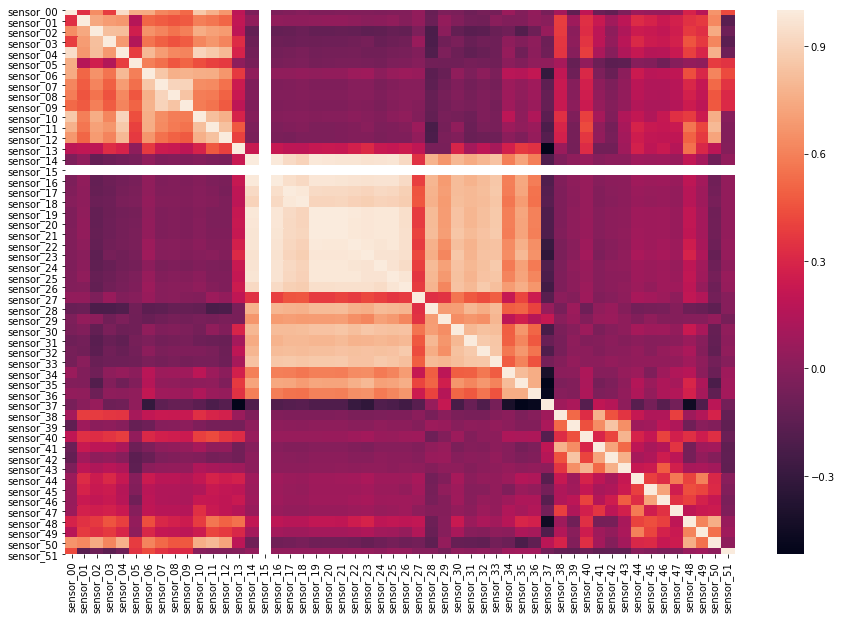

In [11]:
# Look at the correlation between sensor values
sns.heatmap(T.corr())

In [12]:
# Calculate the Explained variance of the first N PCA components

# Only take sensor columns
dcolumns = T.columns[1:-1]

# Standardize data before PCA
sk = StandardScaler()
sk.fit(T[dcolumns])

pca = PCA(n_components=5)
pca.fit(np.nan_to_num(sk.transform(T[dcolumns])))

print(pca.explained_variance_ratio_.sum())
print(pca.explained_variance_ratio_)

# Most important sensors

# np.argsort(abs(pca.components_)[0])[::-1]
# np.argsort(abs(pca.components_)[1])[::-1]

/opt/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


0.7200423403220314
[0.34657298 0.19051463 0.08502661 0.05531747 0.04261065]


## First conclusions
From the ~200k datapoints, most of the sensor are complete.

Exceptions are

•	Sensor 15 (missing completely)

•	Sensor 50: missing ~34%

•	Sensor 51: ~7%

•	Sensor 00: ~ 5% 

A total of 7 broken machine states have been recorded, which have been at least a week apart from each other, and seem to happen more frequently late nights or in the early hours of the day.

Two sets of sensors are highly correlated within each other, maybe indicating similar measurement techniques, locations on the machine?

Using PCA one can explain up to 72% of the variance in the data with 5 PCA components, indicating it might be feasible to work in a reduced PCA state space, although its unclear if this would mask or highlight condition indicators for a failing system.

# Resampling
Check if we can resample the data to get rid of missing data, smooth things a bit and reduce the amount of data

NOTE: sensors 15 and 50 are dropped because of high rate of missing data

In [13]:
T2 = T.copy()
T2.drop(['sensor_15', 'sensor_50'], axis=1, inplace=True)
T2.set_index('timestamp', inplace=True)

In [14]:
sensor_columns = T2.columns[T2.columns.str.contains('sensor_')]

# During resampling peform averaging on sensor and max on machine state (max will prioratize BROKEN and FAILING)
#agg_fun = dict.fromkeys(sensor_columns, np.nanmean)

# Better try median to be less sensible to outliers
agg_fun = dict.fromkeys(sensor_columns, np.median)
agg_fun.update({'machine_status': lambda subset: subset.max()})

# 30 min resampling
rT = T2.resample('30min').agg(agg_fun)

In [15]:
# How many missing data points we have left
rT.isnull().sum().to_frame().T

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
0,337,7,0,0,0,0,156,178,166,150,...,0,0,0,0,0,0,0,0,511,0


In [16]:
# What are the machine states during those sensor errors
rT[rT.isnull().any(axis=1)]['machine_status'].value_counts()

NORMAL        427
RECOVERING    376
BROKEN          1
Name: machine_status, dtype: int64

In [17]:
# There seems no high correlation between BROKEN states and missing data
# do a forward fill
rT.fillna(method='ffill', inplace=True)

In [18]:
rT.machine_status.value_counts()

NORMAL        6856
RECOVERING     481
BROKEN           7
Name: machine_status, dtype: int64

In [19]:
rT[rT.machine_status == 'BROKEN']

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-12 21:30:00,2.381279,52.126740,52.994789,43.402775,399.131923,66.829460,13.317420,16.652200,15.679255,15.086085,...,36.718750,44.791660,52.951390,54.10880,47.453700,43.113430,293.981500,85.069445,225.40505,BROKEN
2018-04-18 00:30:00,1.093982,42.404510,47.482640,41.406250,202.740150,62.394295,10.083910,12.622970,10.127315,10.091150,...,28.906250,36.328120,39.062500,31.53935,35.011572,32.986111,61.053240,52.083330,179.25350,BROKEN
2018-05-19 03:00:00,2.468345,47.178820,52.734370,43.402772,621.817100,78.204645,13.527200,15.856480,15.075230,14.807580,...,32.291662,39.062500,34.722220,35.30093,40.219910,43.402780,143.807900,50.347220,235.38775,BROKEN
2018-05-25 00:30:00,0.055584,48.502605,51.302080,43.315974,3.260995,0.000000,0.028935,17.122400,16.420720,16.355610,...,140.755200,145.833350,39.785880,37.90509,48.611110,56.278935,89.120370,66.406250,146.70140,BROKEN
2018-06-28 22:00:00,0.001968,40.755210,45.334200,40.755207,202.141190,0.000000,3.034578,15.154800,15.227140,15.118630,...,25.000000,29.947918,28.067130,28.64583,29.513889,29.513889,29.224537,29.513889,1000.00000,BROKEN
2018-07-08 00:00:00,0.305961,45.160590,52.994790,45.225691,202.468163,78.827790,1.602286,8.054834,7.783564,7.530382,...,31.640625,34.244790,36.024305,35.01157,37.471065,41.666670,94.762730,43.692130,159.57755,BROKEN
2018-07-25 14:00:00,0.502720,45.833332,52.951390,43.793400,3.104745,52.272620,3.016493,16.167530,15.697340,15.082470,...,36.979165,50.911455,44.994213,44.27083,61.487270,48.611110,226.851850,67.418985,198.20605,BROKEN


In [20]:
trainingT = T2.loc[:'2018-06-01 00:00:00']
validationT = T2.loc['2018-06-01 00:00:01': '2018-07-10 00:00:00']
testingT = T2.loc['2018-07-10 00:00:01':]

In [21]:
trainingT.tail(3)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-05-31 23:58:00,2.448669,46.831596,53.47222,42.621525,642.2454,63.95613,13.49826,16.16753,15.99392,15.05353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NORMAL
2018-05-31 23:59:00,2.459491,46.831600,53.55902,42.621525,623.8426,65.89913,13.64294,16.16753,15.56713,15.16204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NORMAL
2018-06-01 00:00:00,2.454572,46.831600,53.47222,42.621520,628.1250,66.48535,13.62847,16.13136,15.71181,15.16204,...,32.8125,40.10416,40.79861,37.32639,40.79861,39.0625,111.9792,51.79398,183.4491,NORMAL


In [22]:
validationT.head(3)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-06-01 00:01:00,2.454572,46.831600,53.472220,42.621520,628.1250,66.48535,13.62847,16.13136,15.71181,15.16204,...,32.8125,40.10416,40.79861,37.32639,40.79861,39.062500,111.9792,51.79398,183.4491,NORMAL
2018-06-01 00:02:00,2.455556,46.831596,53.472221,42.708330,630.9028,65.38702,13.56337,16.21094,15.81308,15.16204,...,32.8125,39.58333,40.50926,37.32639,41.08796,39.351850,108.7963,51.79398,186.9213,NORMAL
2018-06-01 00:03:00,2.450637,46.831596,53.472221,42.708332,627.1991,65.03825,13.68634,16.07350,15.95052,15.08247,...,32.8125,39.58333,40.50926,36.74768,41.66667,39.351852,106.1921,51.79398,189.5255,NORMAL


In [23]:
validationT.tail(3)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-07-09 23:58:00,2.500810,43.22916,50.13021,44.053820,629.5139,83.98693,14.08420,16.16753,15.99392,15.16204,...,33.59375,38.80208,34.432869,32.986111,36.458330,44.56018,95.19676,44.560180,180.5556,NORMAL
2018-07-09 23:59:00,2.507697,43.18576,50.08680,44.010410,627.5463,83.92052,14.06973,16.16753,15.33565,15.11863,...,33.59375,38.28125,34.432870,32.986110,36.458332,43.69213,95.48611,44.849537,183.7384,NORMAL
2018-07-10 00:00:00,2.508681,43.18576,50.13021,44.010414,634.2593,81.72917,14.03356,16.20370,15.73351,15.08247,...,33.85416,37.50000,33.854170,32.407406,36.168980,42.53472,95.77546,45.138889,190.9722,NORMAL


In [24]:
testingT.head(3)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-07-10 00:01:00,2.508681,43.18576,50.13021,44.010414,634.2593,81.72917,14.03356,16.20370,15.73351,15.08247,...,33.85416,37.50000,33.85417,32.407406,36.168980,42.53472,95.77546,45.138889,190.9722,NORMAL
2018-07-10 00:02:00,2.500810,43.22916,50.08680,44.010414,627.4305,83.56832,14.03356,16.23987,15.26331,15.08247,...,33.59375,36.97916,33.56482,32.407406,35.879630,42.24537,101.56250,45.138889,193.5764,NORMAL
2018-07-10 00:03:00,2.508681,43.22916,50.08680,44.010414,628.3564,83.83752,14.09867,16.12413,15.49479,15.05353,...,33.59375,37.50000,33.56482,32.407406,35.879631,41.95602,109.08560,45.138889,195.0231,NORMAL


# Data Pre-processing
Perform basic pre processing with the goal to prepare the data for modeling
* Split the data into training, validation and test set
* Mark machine state before an BROKEN state as FAILING
* Standardize sensors values
* Add the hour as an additional feature

In [32]:
def data_preprocessing(data, scaler=None, resample_period='5min', sampling_method=np.median, failure_duration='4h', aftermath_duration='2h', mark_failure_cnt=False):
    """
    Perform data preprocessing
        * Standardize data
        * marke the machine state before BROKEN as FAILING
        * create an column containing the hour
    
    Parameters
    ----------
    data : DataFrame
        The dataframe having timestamps, sensor and machine state columns
    scaler : sklearn.preprocessing.StandardScaler
        Specify scaler to use for standardization, leave None to create a new one
    resample_period : str
        Pandas samling period format
    sampling_method : function
        How to aggreagte sensor values for resampling
    failure_state_duration : str
        Duration of machine_status marked as FAILING before a BROKEN state
    aftermath_duration : str
        Duration of machine_status marked as AFTERMATH after a BROKEN state
    mark_failure_cnt: bool
        If true will generate one additional column counting the number of FAILING ranges
    
    Returns
    -------
    DataFrame
        The processed DataFrame
    sklearn.preprocessing.StandardScaler
        Scaler used to standardize the data
    """
    sensor_columns = data.columns[data.columns.str.contains('sensor_')]

    if resample_period:
        # resample with given period and aggregation function
        agg_fun = dict.fromkeys(sensor_columns, sampling_method)
        agg_fun.update({'machine_status': lambda subset: subset.max()})
        pp = data.resample(resample_period).agg(agg_fun)
        pp.fillna(method='ffill', inplace=True)
    else:
        pp = data.copy()
        pp.fillna(method='ffill', inplace=True)

    # Take the hour as an seperate column as breakdowns are more frequent at night
    pp['hour'] = pp.index.hour
    sensor_columns = sensor_columns.append(pd.Index(['hour']))
        
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(pp[sensor_columns])
    
    # Standardize each columns independently
    pp[sensor_columns] = scaler.transform(pp[sensor_columns])
    
    """
    # Create dummy variables indicating missing sensor data
    missing_flags = pp[sensor_columns].isnull().add_suffix('_missing')
    missing_flags['total_missing']=missing_flags.sum(axis=1)
    pp = pd.concat([pp, missing_flags], axis=1)
    """
    
    # Set FAILING states (make sure to not overwrite the broken sate; whats why -1s)
    breakingpoints = pp[pp['machine_status'] == 'BROKEN'].index
    failure_onset = breakingpoints - pd.Timedelta(failure_duration)
    aftermath_offset = breakingpoints + pd.Timedelta(aftermath_duration)
    
    failure_cnt = 1
    pp['failure_cnt'] = 0
        
    for fa_onset, bkp, after_offset in zip(failure_onset, breakingpoints, aftermath_offset):
        #print('Mark as Failing = %s:%s cnt %d' % (fs_onset, ff_offset, failure_cnt))
        
        pp.loc[fa_onset:bkp, 'machine_status'] = 'FAILING'
        pp.loc[bkp:after_offset, 'machine_status'] = 'AFTERMATH'
        # Make sure that Broken state is not lost
        pp.loc[bkp, 'machine_status'] = 'BROKEN'
        pp.loc[fa_onset:bkp-pd.Timedelta('1s'), 'failure_cnt'] = failure_cnt
        failure_cnt+=1
    
    if not mark_failure_cnt:
        pp.drop('failure_cnt', axis=1, inplace=True)
        
    return pp, scaler

In [33]:
trainingTs, scaler = data_preprocessing(trainingT, resample_period='5min')
validationTs, _ = data_preprocessing(validationT, scaler=scaler, resample_period='5min')
testingTs, _ = data_preprocessing(testingT, scaler=scaler, resample_period='5min')

# Data export

In [34]:
print('\ntraining')
print(trainingTs.machine_status.value_counts())

print('\nvalidation')
print(validationTs.machine_status.value_counts())

print('\ntesting')
print(testingTs.machine_status.value_counts())


training
NORMAL        16179
RECOVERING     1098
FAILING         192
AFTERMATH        96
BROKEN            4
Name: machine_status, dtype: int64

validation
NORMAL        9433
RECOVERING    1654
FAILING         96
AFTERMATH       48
BROKEN           2
Name: machine_status, dtype: int64

testing
NORMAL       15191
FAILING         48
AFTERMATH       24
BROKEN           1
Name: machine_status, dtype: int64


In [35]:
from pandas import HDFStore

with HDFStore('data/preprocessed.h5', mode='w') as hdf:
    hdf.put('training', trainingTs)
    hdf.put('validation', validationTs)
    hdf.put('testing', testingTs)   

# Export without resample

In [36]:
trainingTs, scaler = data_preprocessing(trainingT, resample_period=None)
validationTs, _ = data_preprocessing(validationT, scaler=scaler, resample_period=None)
testingTs, _ = data_preprocessing(testingT, scaler=scaler, resample_period=None)

from pandas import HDFStore

with HDFStore('data/preprocessed-noresample.h5', mode='w') as hdf:
    hdf.put('training', trainingTs, format='table')
    hdf.put('validation', validationTs, format='table')
    hdf.put('testing', testingTs, format='table')  

In [37]:
trainingTs.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status,hour
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,0.349433,-0.215538,0.555114,1.168128,0.321040,0.221695,0.257898,0.225184,0.285102,0.199425,...,-0.122011,-0.111943,2.012014,0.398743,-0.519024,0.592863,0.880340,0.325107,NORMAL,-1.661289
2018-04-01 00:01:00,0.349433,-0.215538,0.555114,1.168128,0.321040,0.221695,0.257898,0.225184,0.285102,0.199425,...,-0.122011,-0.111943,2.012014,0.398743,-0.519024,0.592863,0.880340,0.325107,NORMAL,-1.661289
2018-04-01 00:02:00,0.311555,-0.111806,0.555114,1.206575,0.354754,0.080306,0.222783,0.189862,0.307011,0.181758,...,-0.139921,-0.149209,1.986690,0.419177,-0.519024,0.559382,0.841648,0.369762,NORMAL,-1.661289
2018-04-01 00:03:00,0.340413,-0.215538,0.541174,1.206574,0.274361,0.247375,0.219858,0.268666,0.341437,0.211205,...,-0.193650,-0.186476,1.936040,0.419177,-0.519024,0.559382,0.822303,0.358598,NORMAL,-1.661289
2018-04-01 00:04:00,0.313359,-0.198251,0.555114,1.206574,0.336600,0.227965,0.234489,0.255078,0.341437,0.211205,...,-0.157830,-0.223743,1.961364,0.460047,-0.448865,0.597647,0.802957,0.325107,NORMAL,-1.661289


In [38]:
trainingTs.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,hour
count,8.784100e+04,8.784100e+04,8.784100e+04,8.784100e+04,8.784100e+04,8.784100e+04,8.784100e+04,8.784100e+04,8.784100e+04,8.784100e+04,...,8.784100e+04,8.784100e+04,8.784100e+04,8.784100e+04,8.784100e+04,8.784100e+04,8.784100e+04,8.784100e+04,8.784100e+04,8.784100e+04
mean,1.346004e-16,-3.820580e-15,3.592794e-15,-2.787781e-15,-2.899085e-16,3.856818e-16,-5.176937e-16,4.840436e-16,6.005247e-16,3.002624e-16,...,1.475427e-16,8.283100e-17,-2.588469e-18,4.083309e-16,3.934472e-16,-5.358130e-16,1.242465e-16,2.769661e-16,-1.760159e-16,-4.529820e-17
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,...,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-4.170642e+00,-1.003543e+01,-4.798269e+00,-4.598523e+00,-4.395518e+00,-3.488454e+00,-5.161300e+00,-5.834567e+00,-6.437530e+00,-5.925261e+00,...,-8.746165e-01,-1.107047e+00,-1.788956e+00,-1.432100e+00,-1.236043e+00,-1.781884e+00,-1.545098e+00,-1.770035e+00,-2.973793e+00,-1.661289e+00
25%,2.484255e-01,-4.748653e-01,-1.698220e-01,-5.041997e-01,2.544786e-01,-1.803444e-02,1.613338e-01,6.758001e-02,9.105725e-02,1.375888e-01,...,-2.755882e-01,-3.190180e-01,-5.964127e-01,-5.204232e-01,-4.390852e-01,-5.190244e-01,-7.798319e-01,-5.319035e-01,-1.605177e-01,-9.389813e-01
50%,3.277882e-01,4.378943e-02,2.065892e-01,1.685761e-01,2.959722e-01,2.263844e-01,2.461916e-01,2.251841e-01,1.661700e-01,2.112049e-01,...,-8.178469e-02,-1.041011e-01,-1.492090e-01,-1.912061e-01,-1.938675e-01,-9.807040e-02,-1.819683e-01,-2.223707e-01,1.855594e-01,-7.221188e-02
75%,3.422172e-01,5.451613e-01,5.969377e-01,6.875749e-01,3.331429e-01,4.575906e-01,3.310494e-01,2.550784e-01,2.913622e-01,2.259240e-01,...,1.120184e-01,1.466351e-01,3.725289e-01,1.886598e-01,1.535242e-01,2.878036e-01,6.406919e-01,2.225826e-01,5.260557e-01,7.945576e-01
max,5.027468e-01,3.242175e+00,1.321877e+00,1.937019e+00,6.019845e-01,1.363961e+00,3.485423e+00,2.996913e+00,2.817042e+00,2.731749e+00,...,2.285749e+01,2.509490e+01,2.325445e+01,1.553523e+01,1.946443e+01,1.870451e+01,6.284526e+00,1.796268e+01,5.432539e+00,1.661327e+00
